In [65]:
import pandas as pd

In [66]:
scores = pd.read_csv('/home/pooja/pooja/unil/transcripts/self_promotion_scores_new.csv',sep=",")

In [67]:
scores.drop(scores.columns[[0,4,5,10,11,12,13]],axis =1,inplace = True)

### Checking for null values removing rows if any

In [68]:
count_nan = scores['osprom5'].isnull().sum()
print(count_nan)

0


### Creating the interview dataset by reading transcripts.

In [69]:
# scores.drop_duplicates(subset=["videoDate"],inplace=True)
scores.drop_duplicates(subset=["feedbackNo"],inplace=True)
scores.sort_values(by="videoDate",inplace=True)
scores

,feedbackNo,userId,videoDate,osprom1,osprom2,osprom3,osprom5
0,1,3,1629557170507,2,3,2,2
6,7,3,1629557170507,4,2,2,2
1,2,4,1629562423256,6,7,7,6
11,12,4,1629562423256,3,3,2,2
7,8,4,1629562423256,3,3,5,5
...,...,...,...,...,...,...,...
388,389,196,1651087872228,1,1,1,1
389,390,11,1651606592874,6,6,5,6
390,391,309,1652274885170,2,2,3,2
391,392,230,1652433981916,3,2,2,2


### Modifying the date so that it can be used to search transcripts : 

In [70]:
scores["videoDate"] = scores["videoDate"].astype(int)

In [71]:
import os
path = "/home/pooja/pooja/unil/transcripts/transcripts/"
filelist = []
datelist = []
for entry in os.listdir(path):
    if os.path.isfile(os.path.join(path, entry)):
        filelist.append(path+entry)
        datelist.append(entry[0:13])
filelist.sort()

In [72]:
datelist = [*set(datelist)]
datelist.sort()

In [73]:
data = {
    'videoDate' : [],
    'interview' : [],
    'ts1' : [],
    'ts2' : [],
    'ts3' : [],
    'ts4' : [],
    'ts5' : []
    }
for date in datelist : 
    interviewDate = date
    interview = ""
    ts1 = ""
    ts2 = ""
    ts3 = ""
    ts4 = ""
    ts5 = ""
    for file in filelist :
        if (file[len(path):len(path)+13] == date) :
            f = open(file)
            s = f.read().replace('|','')
            s = s.replace('\"','')
            if (file[-5] == '1') :
                ts1 += s
            if (file[-5] == '2') :
                ts2 += s
            if (file[-5] == '3') :
                ts3 += s
            if (file[-5] == '4') :
                ts4 += s
            if (file[-5] == '5') :
                ts5 += s
            interview = interview + s
        # print(interview)
    data['videoDate'].append(interviewDate)
    data['interview'].append(interview)
    data['ts1'].append(ts1)
    data['ts2'].append(ts2)
    data['ts3'].append(ts3)
    data['ts4'].append(ts4)
    data['ts5'].append(ts5)



interviewdf = pd.DataFrame(data)            

In [74]:
interviewdf.drop_duplicates(subset="videoDate")
interviewdf["videoDate"] = interviewdf["videoDate"].astype(int)

### There are videos that have the same exact date

In [75]:
scores = scores.drop_duplicates(subset="videoDate")
scores
finaldf = pd.merge(scores,interviewdf, on="videoDate")

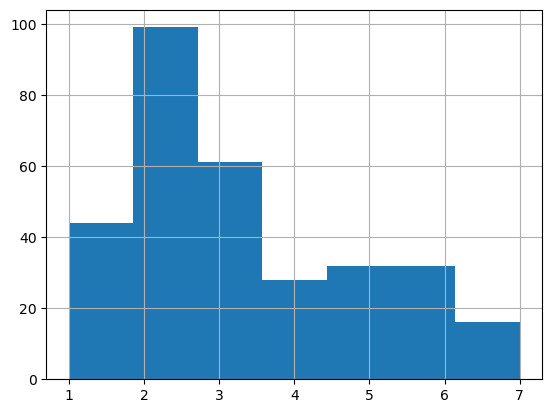

In [76]:
import matplotlib.pyplot as plt
hist = finaldf['osprom1'].hist(bins=7)

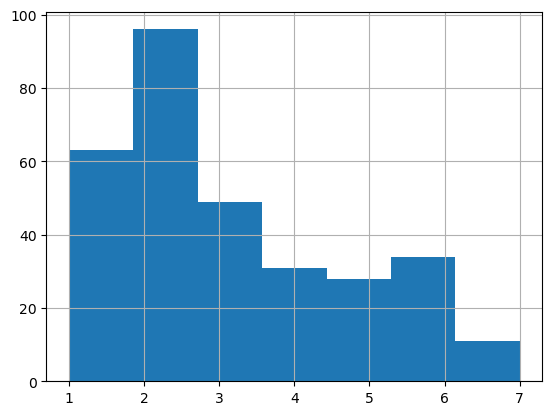

In [77]:
hist = finaldf['osprom2'].hist(bins=7)

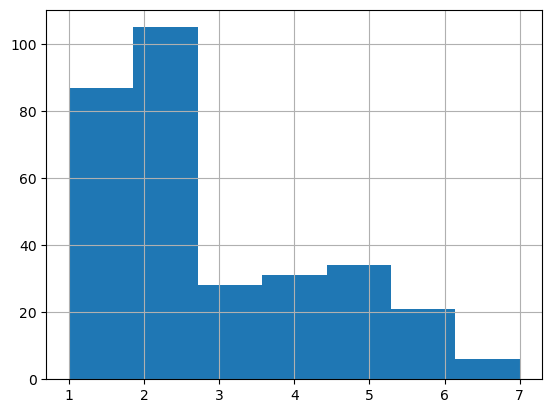

In [78]:
hist = finaldf['osprom3'].hist(bins=7)

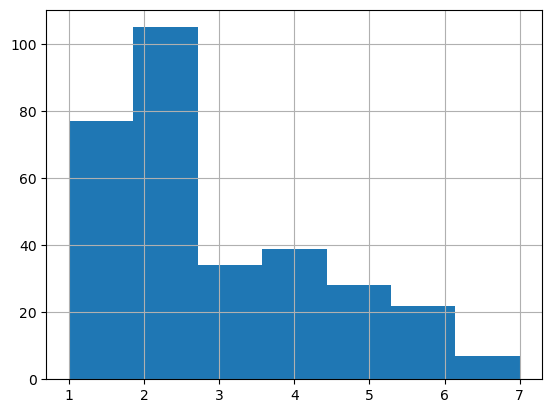

In [79]:
hist = finaldf['osprom5'].hist(bins=7)

### Since osprom2 is based on "Make people aware of your talents or qualifications."

In [80]:
def func(x):
    return (1 if x>3 else 0)
# t = finaldf["osprom2"].apply(func)


In [81]:
finaldf['ts1'] = finaldf['ts1'].fillna("")
finaldf['ts2'] = finaldf['ts2'].fillna("")
finaldf['ts3'] = finaldf['ts3'].fillna("")
finaldf['ts4'] = finaldf['ts4'].fillna("")
finaldf['ts5'] = finaldf['ts5'].fillna("")
finaldfcopy = finaldf.copy()

### Applying mask to osprom2 

In [82]:
def func(x):
    return (1 if x>3 else 0)
finaldfcopy["osprom2"] = finaldfcopy["osprom2"].apply(func)


### testing for classification using bert.

In [83]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [84]:
answers = finaldfcopy.values[:,7]
labels = finaldfcopy.values[:,4].astype(float)
embeddings = bert_model.encode(answers, show_progress_bar=True)
print (embeddings.shape)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(312, 768)


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, 
                                          test_size=0.2, random_state=42)
print ("Training set shapes:", X_train.shape, y_train.shape)
print ("Test set shapes:", X_test.shape, y_test.shape)

Training set shapes: (249, 768) (249,)
Test set shapes: (63, 768) (63,)


In [86]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import LSTM
classifier = Sequential()
classifier.add (layers.Dense(256, activation='relu', input_shape=(768,)))##256 for the depression dataset
classifier.add (layers.Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
    
hist = classifier.fit (X_train, y_train, epochs=2, batch_size=16, 
                      validation_data=(X_test, y_test))
#10 epochs for depression data.

Epoch 1/2
16/16 [==============================] - 1s 16ms/step - loss: 0.6386 - accuracy: 0.6506 - val_loss: 0.5522 - val_accuracy: 0.7143
Epoch 2/2
16/16 [==============================] - 0s 7ms/step - loss: 0.6226 - accuracy: 0.6827 - val_loss: 0.6214 - val_accuracy: 0.7302


In [87]:
count = 0
for i in y_test :
    if i == 1 :
        count +=1
print(count/len(y_test))


0.30158730158730157


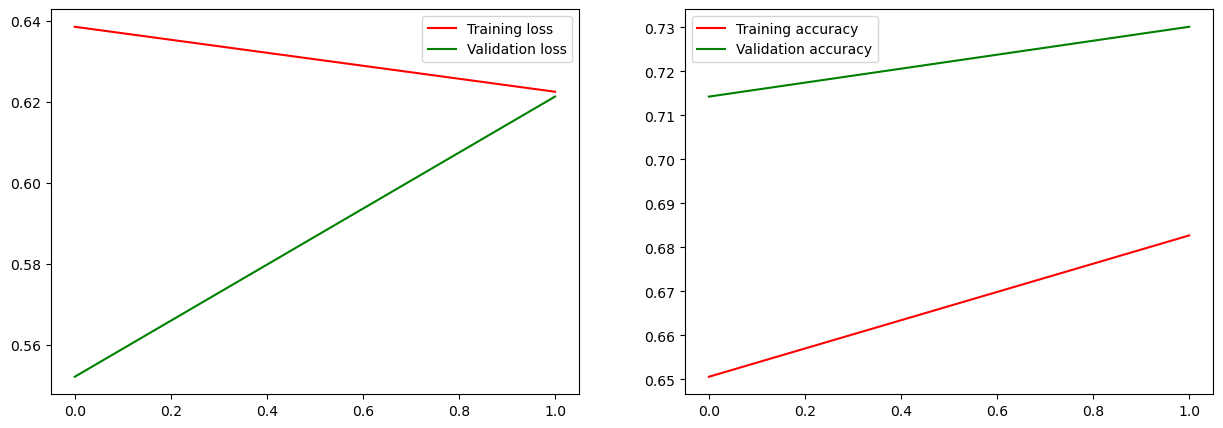

In [88]:
from matplotlib import pyplot

pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(hist.history['loss'], 'r', label='Training loss')
pyplot.plot(hist.history['val_loss'], 'g', label='Validation loss')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(hist.history['accuracy'], 'r', label='Training accuracy')
pyplot.plot(hist.history['val_accuracy'], 'g', label='Validation accuracy')
pyplot.legend()
pyplot.show()

In [89]:
# rnn_model = Sequential()
# rnn_model.add(LSTM(units = 128, dropout = 0.3, recurrent_dropout = 0.3))
# rnn_model.add(layers.Dense(units = 1, activation = 'sigmoid')) 
# rnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
# # history = rnn_model.fit(X_train.reshape(-1,1,768), y_train, batch_size = 16, epochs = 10, validation_data = (X_test.reshape(-1,1,768), y_test))
# rnn_model.evaluate(X_test.reshape(-1,1,768), y_test)
# ypred = rnn_model.predict(X_test.reshape(-1,1,768))

### TODO : Try out just transcript 2 and osprom2  (Seems like a bad avenue put to hold)
### Try out all scores combined and the entire interview
### If all else fails or options exhausted try an ensemble use lingfeat from spacy and generate the features pass to XGBoost or Logistic regression or some other model

In [90]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
compInterview = []
negInterview = []
posInterview = []
neuInterview = []
for i in finaldfcopy['interview'] :
    polarityscores = sia.polarity_scores(i)
    compInterview.append(polarityscores['compound'])
    neuInterview.append(polarityscores['neu'])
    negInterview.append(polarityscores['neg'])
    posInterview.append(polarityscores['pos'])

finaldfcopy['compInterview'] = compInterview
finaldfcopy['neuInterview'] = neuInterview
finaldfcopy['negInterview'] = negInterview
finaldfcopy['posInterview'] = posInterview



### Approach I - average score approach with all the Transcripts except Transcript 1:

In [91]:
averageScore = (finaldfcopy.values[:,3].astype(float) + finaldfcopy.values[:,4].astype(float) + finaldfcopy.values[:,5].astype(float) + finaldfcopy.values[:,6].astype(float))/4

In [92]:
averageScore
count = 0
for i in range(len(averageScore)) :
    if averageScore[i] >3 :
        averageScore[i] = 1
        count += 1
    else :
        averageScore[i] = 0
print(averageScore)
print("Total number of 1s ", count/len(averageScore))

[0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
Total number of 1s  0.28846153846153844


### AverageScore Vs Ts2

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(312, 768)
Training set shapes: (249, 768) (249,)
Test set shapes: (63, 768) (63,)
1s in test :  19 Total :  63
BLIND GUESS ACCURACY :  69.84126984126985
Epoch 1/3
16/16 [==============================] - 1s 17ms/step - loss: 0.7886 - accuracy: 0.6988 - val_loss: 0.6077 - val_accuracy: 0.7302
Epoch 2/3
16/16 [==============================] - 0s 8ms/step - loss: 0.5107 - accuracy: 0.7470 - val_loss: 0.5769 - val_accuracy: 0.7619
Epoch 3/3
16/16 [==============================] - 0s 8ms/step - loss: 0.4454 - accuracy: 0.7952 - val_loss: 0.5813 - val_accuracy: 0.7460


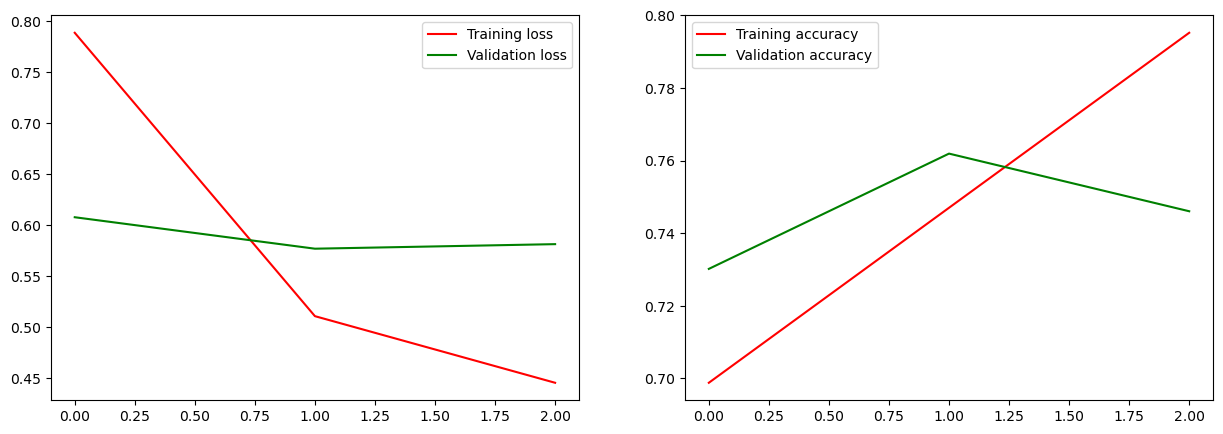

In [93]:
answers = finaldfcopy.values[:,9] ##only TS2
labels = averageScore
embeddings = bert_model.encode(answers, show_progress_bar=True)
print (embeddings.shape)
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, 
                                          test_size=0.2, random_state=42)
print ("Training set shapes:", X_train.shape, y_train.shape)
print ("Test set shapes:", X_test.shape, y_test.shape)
classifier = Sequential()
classifier.add (layers.Dense(256, activation='relu', input_shape=(768,)))##256 for the depression dataset
classifier.add (layers.Dropout(0.3))
classifier.add (layers.Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
count = 0
for i in y_test : 
    if(i == 1):
        count +=1
print("1s in test : ",count, "Total : ",len(y_test))
print("BLIND GUESS ACCURACY : ", 100 - count/len(y_test)*100)
hist = classifier.fit (X_train, y_train, epochs=3, batch_size=16, 
                      validation_data=(X_test, y_test))
pyplot.figure(figsize=(15,5))
pyplot.subplot(1, 2, 1)
pyplot.plot(hist.history['loss'], 'r', label='Training loss')
pyplot.plot(hist.history['val_loss'], 'g', label='Validation loss')
pyplot.legend()
pyplot.subplot(1, 2, 2)
pyplot.plot(hist.history['accuracy'], 'r', label='Training accuracy')
pyplot.plot(hist.history['val_accuracy'], 'g', label='Validation accuracy')
pyplot.legend()
pyplot.show()

# Handcrafted Features

So, the features that we will be using are:
- EnGF_
- PhrF_
- POSF_
- VarF_

The 255 features that have been used for readability using lingfeat might not all be applicable to self-promotion. The following are the linguistic branches that are part of the 255 features in lingfeat:

- Advanced Semantics (AdSem) (WoKF_, WBKF_, OSKF_ Subgroups): These are the features which tell us about the semantic richness of the text. This includes features extracted from Wikipedia (Wiki Knowledge Features), WeeBit (WB Knowledge Features) and OneStop English (OSE Knowledge Features). Some feature examples are: (Semantic Richness, 200 topics extracted from OneStopEng Corpus), (Number of topics, 200 topics extracted from WeeBit Corpus), etc. As features like Semantic Richness, Semantic Noise, Semantic Clarity and Number of Topics are not important for Self-Promotion, we can ignore these features. 
- Discourse (Disco) (EnDF_, EnGF_ Subgroups): These subgroups have features which tell us about the coherence of sentences and other features like unique entity mentions. From these, coherence features might be useful for us (EnGF_) as they will help in situations where the person is trying to tell a story/anecdote, but features like 'average number of unique Entities per token (word)' or 'average number of unique Entities per sentence', which are included in EnDF_ might not be useful for us (Review)
- Syntax (Synta) (PhrF_, TrSF_, POSF_ subgroups): Syntax inlcudes three types of features, Phrasal Features, Tree Structure Features and Part of Speech Features. These might be the most useful for us to determine Self Promotion as they have features like 'total count of Noun phrases' (PhrF_), 'total Tree height of all sentences' (TrSF_) and 'total count of Noun POS tags' (POSF_). PhrF_ and POSF_ are very useful for us, while TrSF_ might not be as useful (Review)
- Lexico Semantic (LxSem) (VarF_, TTRF_, PsyF_, WorF_ Subgroups): These include features which tell us the variation ratios between different types of phrases (VarF_), eg. 'unique Nouns/total Nouns (Noun Variation-1)', features which tell us about different ratios between unique tokens and total number of tokens (TTRF_), eg. 'unique tokens/total tokens (TTR)', features which tell us about Age of Acquisition of different of lemmas in the text (PsyF_), eg. 'total AoA (Age of Acquisition) of words' and features which tell us about the word familiarity in the text (WorF_), eg. 'total SubtlexUS FREQcount value'. Out of these only VarF_ seems to be useful (Review)
- Shallow Traditional (ShaF_, TraF_, Subgroups): These subgroups have features which tell us about the basic details about the text. Like 'total count of tokens x total count of sentence' (ShaF_) and 'Smog Index' (TraF_). These features are not of much use to us.


Link for reference: https://github.com/brucewlee/lingfeat

In [94]:
from lingfeat import extractor

In [95]:
import numpy as np

In [96]:
badIndices = pd.read_csv('badIndices.csv', header=None)

In [97]:
arr = badIndices.to_numpy().reshape(-1,)
arr

array([ 42,  44,  98, 107, 120, 145, 172, 200, 243, 275, 308])

In [98]:
finaldfcopy_noerror = finaldfcopy.drop(axis='rows', labels=arr)

In [99]:
averageScoreNew = np.delete(averageScore, arr)

In [100]:
averageScoreNew.shape

(301,)

In [101]:
feature_df = pd.read_csv('./interview_feature_extraction_df.csv')
feature_df.drop(axis='columns', labels=['Unnamed: 0'], inplace=True)

In [102]:
feature_df_low_var = feature_df.drop(axis='columns', labels=[col for col in feature_df.columns if feature_df[col].var() < 0.1])

In [103]:
import tensorflow_decision_forests as tfdf
from sklearn.metrics import accuracy_score

## Adding more features to the handcrafted features

### Sentiment Analysis using VADER

Using VADER as it is sensitive towards positive or negative sentiments

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8989068/#:~:text=A%20lexicon%20is%20a%20set,are%20WordNet%2C%20SenticNet%2C%20etc.

In [104]:
# pip install vaderSentiment

In [105]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

VADER scores of:
- \> 0.05 are positive
- < 0.05 and > -0.05 are neutral
- < -0.05 are negative

But to retain information, we will just use the compound scores.

In [106]:
sentimentFeatureDict = {}

sentimentAnalyzer = SentimentIntensityAnalyzer()

tempDict = sentimentAnalyzer.polarity_scores(finaldfcopy_noerror['interview'][0])
sentimentFeatureDict['compound'] = [tempDict['compound']]

for i, row in enumerate(finaldfcopy_noerror['interview']):
    if i > 0:
        tempDict = sentimentAnalyzer.polarity_scores(row)
        sentimentFeatureDict['compound'].append(tempDict['compound'])

sentiment_df = pd.DataFrame(sentimentFeatureDict)


In [107]:
feature_df = pd.concat([feature_df, sentiment_df], axis=1, join='inner')
feature_df.shape

(301, 138)

### YE WALA Neural Model (BERT) - LF-Features + Sentiment -> Non-Neural Model (Random Forest) - LF-Features + Sentiment

#### Sklearn Feature importance

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

In [109]:
readings = []

for i in range(3):
    answers = finaldfcopy_noerror.values[:, 7]
    labels = averageScoreNew
    embeddings = bert_model.encode(answers, show_progress_bar=True)
    print (embeddings.shape)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, 
                                            test_size=0.2,random_state = 42)
    print ("Training set shapes:", X_train.shape, y_train.shape)
    print ("Test set shapes:", X_test.shape, y_test.shape)
    classifier = Sequential()
    classifier.add (layers.Dense(256, activation='relu', input_shape=(embeddings.shape[1],)))##256 for the depression dataset
    classifier.add (layers.Dropout(0.3))
    classifier.add (layers.Dense(1, activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
    count = 0
    for i in y_test : 
        if(i == 1):
            count +=1
    print("1s in test : ",count, "Total : ",len(y_test))
    print("BLIND GUESS ACCURACY : ", 100 - count/len(y_test)*100)
    classifier.fit (X_train, y_train, epochs=3, batch_size=16, 
                        validation_data=(X_test, y_test))
    # NEWLY ADDED START
    predictions = classifier.predict(x=embeddings)
    for i, prd in enumerate(predictions):
        if prd >= 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0

    feature_df_rf = feature_df.copy()
    feature_df_rf['prediction'] = predictions

    X_train, X_test, y_train, y_test = train_test_split(feature_df_rf, labels, 
                                            test_size=0.2, random_state = 42)
    feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
    # rfc_gscv = RandomForestClassifier(random_state=42, n_estimators=350, max_features='auto', max_depth=7)
    rfc_gscv = RandomForestClassifier(random_state=42)
    rfc_gscv.fit(X_train, y_train)



    pred_train = rfc_gscv.predict(X_train)
    pred_test = rfc_gscv.predict(X_test)

    print(accuracy_score(pred_train, y_train))
    print(accuracy_score(pred_test, y_test))


    importances = rfc_gscv.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc_gscv.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending = False)

    readings.append(forest_importances)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)
Training set shapes: (240, 768) (240,)
Test set shapes: (61, 768) (61,)
1s in test :  16 Total :  61
BLIND GUESS ACCURACY :  73.77049180327869
Epoch 1/3
15/15 [==============================] - 1s 16ms/step - loss: 0.6959 - accuracy: 0.6792 - val_loss: 0.5515 - val_accuracy: 0.7377
Epoch 2/3
15/15 [==============================] - 0s 7ms/step - loss: 0.4775 - accuracy: 0.7833 - val_loss: 0.5364 - val_accuracy: 0.7377
Epoch 3/3
10/10 [==============================] - 0s 3ms/step
1.0
0.8852459016393442


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)
Training set shapes: (240, 768) (240,)
Test set shapes: (61, 768) (61,)
1s in test :  16 Total :  61
BLIND GUESS ACCURACY :  73.77049180327869
Epoch 1/3
15/15 [==============================] - 1s 17ms/step - loss: 0.7175 - accuracy: 0.6500 - val_loss: 0.7293 - val_accuracy: 0.7377
Epoch 2/3
15/15 [==============================] - 0s 7ms/step - loss: 0.5865 - accuracy: 0.7125 - val_loss: 0.5814 - val_accuracy: 0.7213
Epoch 3/3
10/10 [==============================] - 0s 2ms/step
1.0
0.8688524590163934


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(301, 768)
Training set shapes: (240, 768) (240,)
Test set shapes: (61, 768) (61,)
1s in test :  16 Total :  61
BLIND GUESS ACCURACY :  73.77049180327869
Epoch 1/3
15/15 [==============================] - 1s 15ms/step - loss: 0.7174 - accuracy: 0.6667 - val_loss: 0.5551 - val_accuracy: 0.7377
Epoch 2/3
15/15 [==============================] - 0s 7ms/step - loss: 0.5268 - accuracy: 0.7458 - val_loss: 0.5343 - val_accuracy: 0.7213
Epoch 3/3
10/10 [==============================] - 0s 2ms/step
1.0
0.9016393442622951


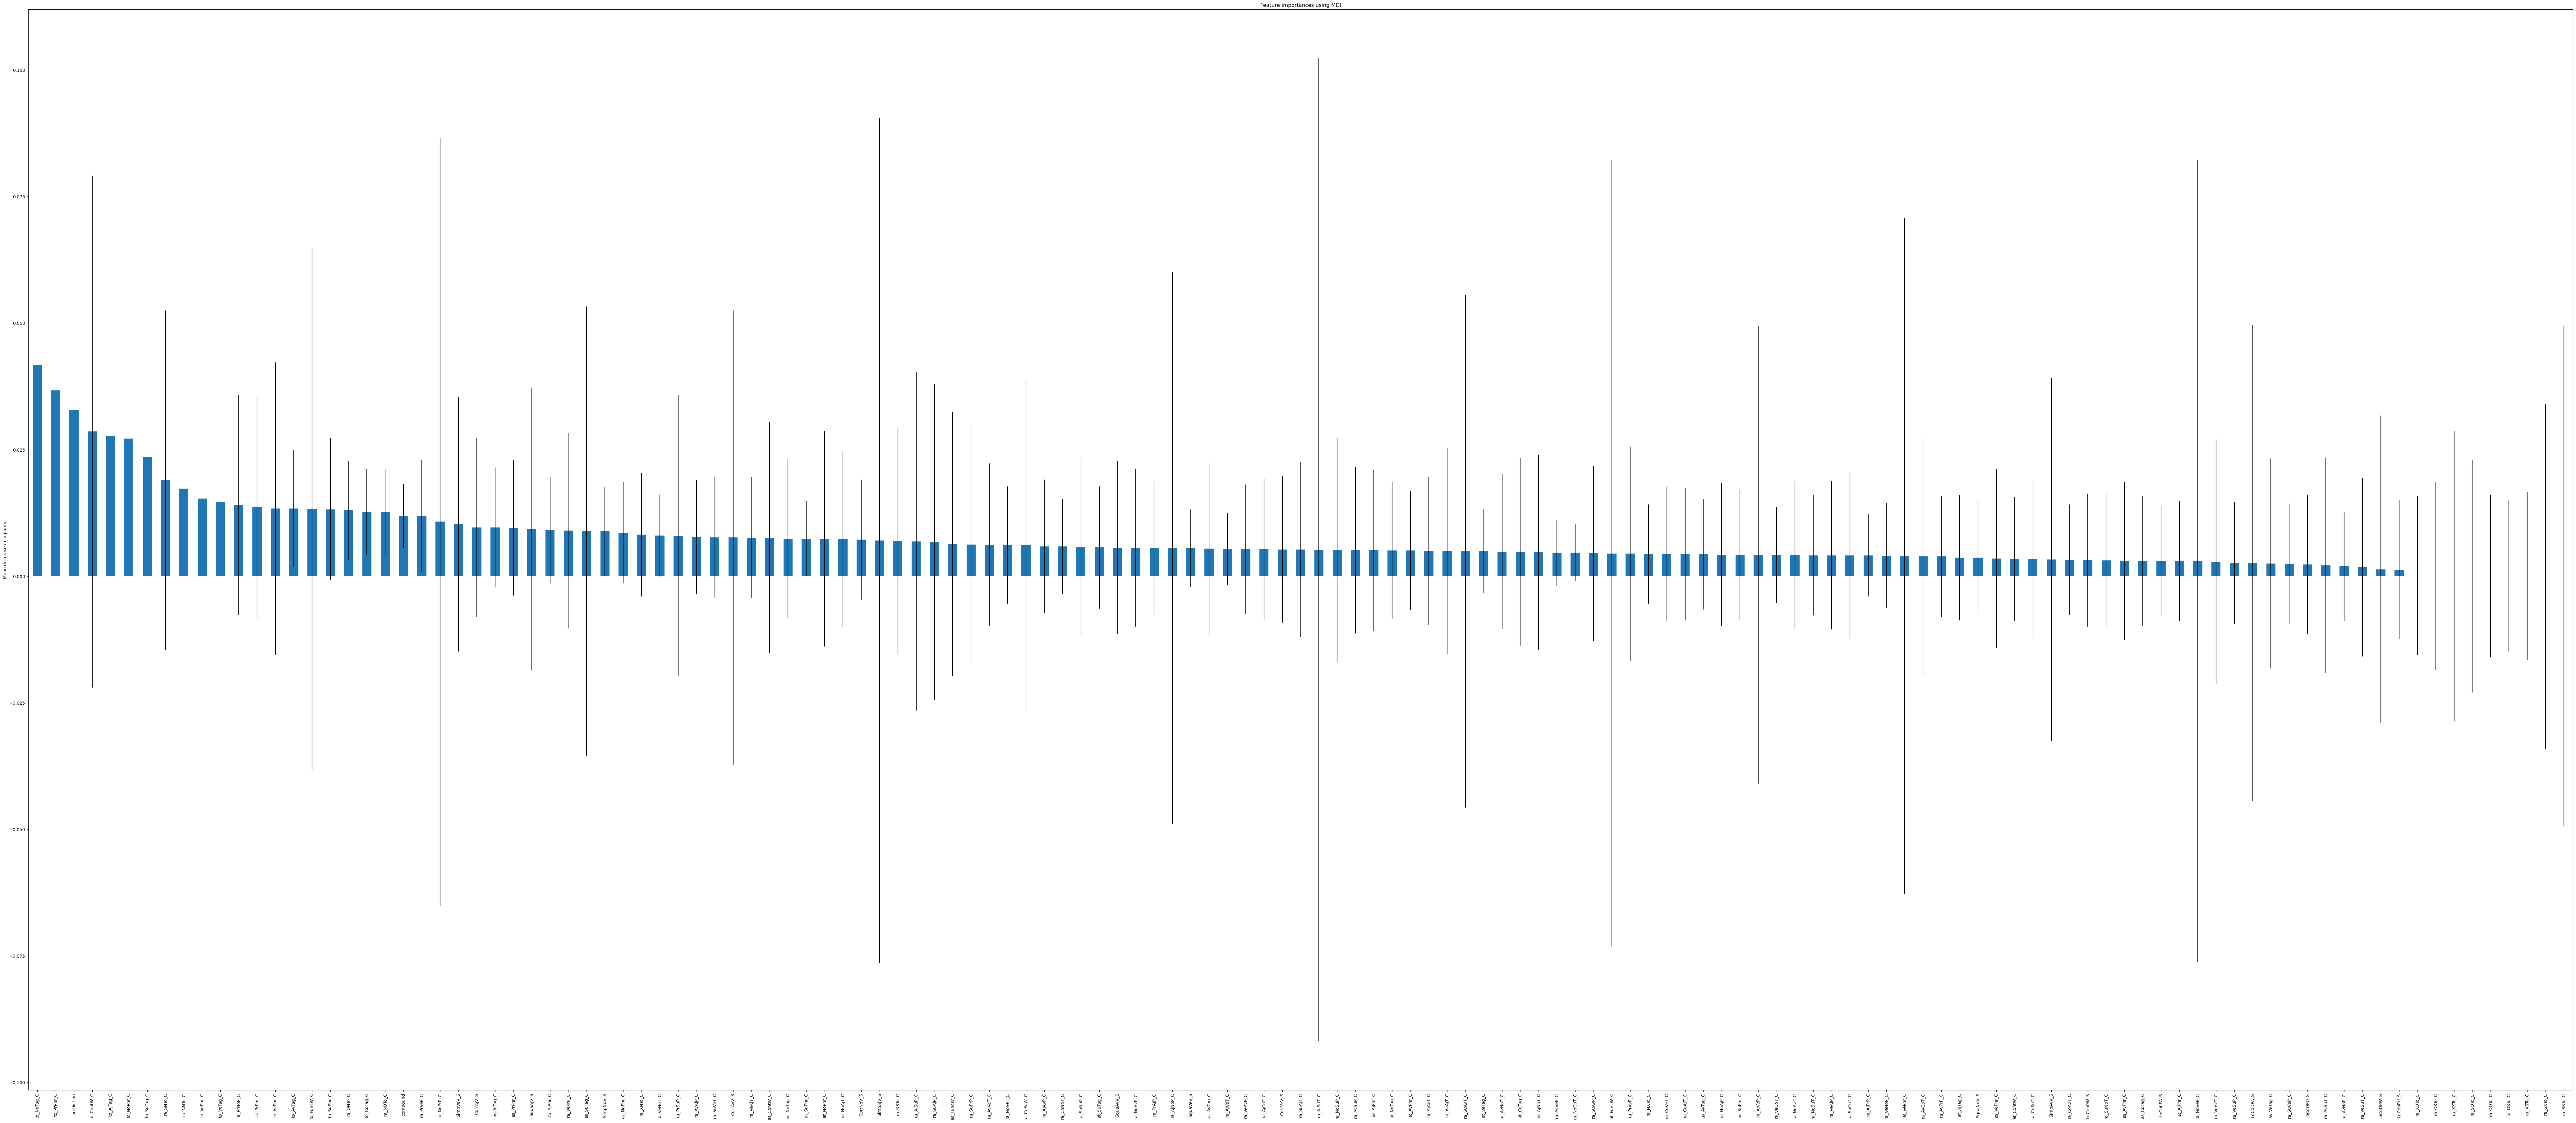

In [110]:
finalreading = readings[0]+readings[1]+readings[2]
finalreading = finalreading.sort_values(ascending = False)
finalreading = finalreading/3

indexes = []
for x in range(139):
    indexes.append('feature ' + str(x))

finalreading = finalreading.rename(index = dict(zip(indexes,feature_df_rf.columns)))

fig, ax = plt.subplots()
finalreading.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.gcf().set_size_inches(100, 50)

Top 10 most important features

In [111]:
finalreading[:10]

to_NoTag_C    0.041749
to_PrPhr_C    0.036724
prediction    0.032787
to_ContW_C    0.028579
to_AjTag_C    0.027751
to_NoPhr_C    0.027168
to_SuTag_C    0.023571
ra_SNTo_C     0.018964
ra_NNTo_C     0.017319
to_VePhr_C    0.015337
dtype: float64

Most important features of features:
prediction: prediction from the BERT model
to_NoTag_C: total count of Noun POS tags
to_PrPhr_C: total count of prepositional phrases
to_ContW_C: total count of Content words
to_AjTag_C: total count of Adjective POS tags
to_NoPhr_C: total count of Noun phrases
to_SuTag_C: total count of Subordinating Conjunction POS tags


Top 10 least important features

In [112]:
finalreading[-10:]

LoCohPU_S    0.001283
ra_XOTo_C    0.000110
ra_OXTo_C    0.000000
ra_XXTo_C    0.000000
ra_SOTo_C    0.000000
ra_OOTo_C    0.000000
ra_OSTo_C    0.000000
ra_XSTo_C    0.000000
ra_SXTo_C    0.000000
ra_SSTo_C    0.000000
dtype: float64

#### Shap Explainer

In [113]:
import shap
from shap import Explainer, Explanation, waterfall_plot
caseno = 1
pred_test = rfc_gscv.predict(X_test)
print("prediction: "+str(pred_test[caseno]))


explainer = shap.TreeExplainer(rfc_gscv)

choosen_instance = X_test.iloc[caseno]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)


    

prediction: 0.0


prediction: 0.0


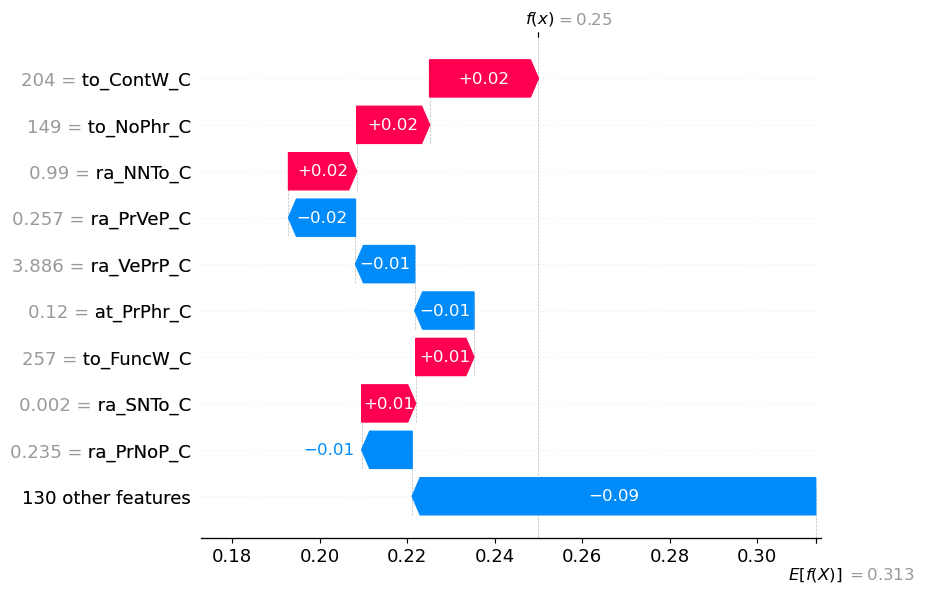

In [114]:

print("prediction: "+str(pred_test[caseno]))
explainer = Explainer(rfc_gscv)
sv = explainer(X_test)

exp = Explanation(sv[:,:,1], sv.base_values[:,1], X_test, feature_names=X_test.columns)

waterfall_plot(exp[caseno])

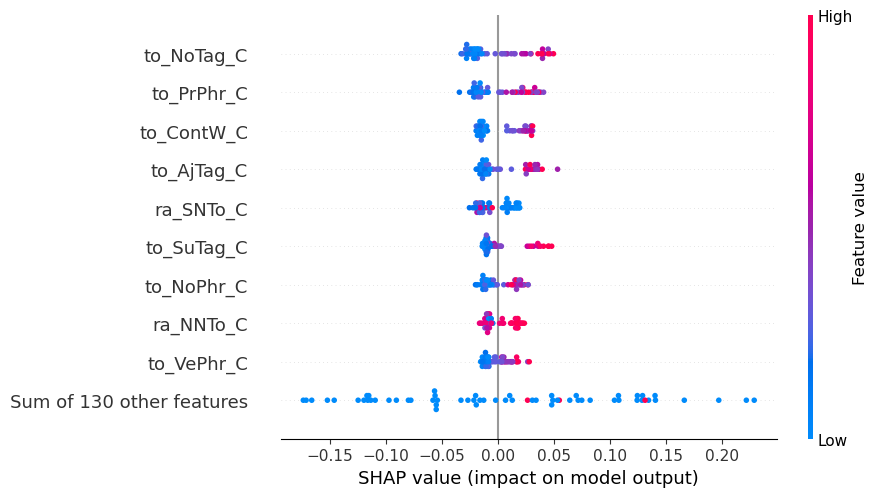

In [115]:
shap.plots.beeswarm(exp)

### DiCE counterfactuals

In [116]:
import dice_ml
from dice_ml.utils import helpers # helper functions

In [117]:
X_train['target'] = y_train

In [118]:
d = dice_ml.Data(dataframe=X_train, continuous_features=list(X_train.columns[:-2]), outcome_name='target')

# Pre-trained ML model
m = dice_ml.Model(model=rfc_gscv, backend="sklearn")
# DiCE explanation instance
exp = dice_ml.Dice(d,m)

In [119]:
e1 = exp.generate_counterfactuals(X_test[1:2], total_CFs=5, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,ra_SSTo_C,ra_SOTo_C,ra_SXTo_C,ra_SNTo_C,ra_OSTo_C,ra_OOTo_C,ra_OXTo_C,ra_ONTo_C,ra_XSTo_C,ra_XOTo_C,...,CorrVeV_S,SimpAjV_S,SquaAjV_S,CorrAjV_S,SimpAvV_S,SquaAvV_S,CorrAvV_S,compound,prediction,target
0,0.0,0.0,0.0,0.001559,0.0,0.0,0.0,0.001559,0.0,0.0,...,1.426608,0.727273,11.636364,2.412091,0.340909,5.113636,1.599005,0.9964,0.0,0



Diverse Counterfactual set (new outcome: 1.0)


,ra_SSTo_C,ra_SOTo_C,ra_SXTo_C,ra_SNTo_C,ra_OSTo_C,ra_OOTo_C,ra_OXTo_C,ra_ONTo_C,ra_XSTo_C,ra_XOTo_C,...,CorrVeV_S,SimpAjV_S,SquaAjV_S,CorrAjV_S,SimpAvV_S,SquaAvV_S,CorrAvV_S,compound,prediction,target
0,-,-,-,0.0015592515592515,-,-,-,0.0015592515592515,-,-,...,1.4266083091043715,0.7272727272727273,11.636363636363637,2.412090756622109,0.3409090909090909,5.0,1.7,0.9964,1.0,-
1,-,-,-,0.0015592515592515,0.1,-,-,0.1,-,-,...,1.4266083091043715,0.7272727272727273,11.636363636363637,2.412090756622109,0.3409090909090909,6.01363636363636,1.599005372667078,0.9964,1.0,1
2,-,-,-,0.0015592515592515,-,-,-,0.0015592515592515,-,-,...,1.4266083091043715,0.7272727272727273,11.636363636363637,2.412090756622109,0.3409090909090909,6.01363636363636,1.599005372667078,0.9964,1.0,1
3,-,-,-,0.0015592515592515,0.1,-,-,0.1,-,-,...,1.4266083091043715,0.7272727272727273,11.636363636363637,2.412090756622109,0.3409090909090909,6.01363636363636,1.599005372667078,0.9964,1.0,1
4,-,-,-,0.0015592515592515,-,-,-,0.0015592515592515,-,-,...,1.4266083091043715,0.7272727272727273,11.636363636363637,2.412090756622109,0.3409090909090909,6.01363636363636,1.599005372667078,0.9964,1.0,1
